# 'SCZ1_TEMP', 'SCZ2_TEMP' -> Outliers 없음 -> GRU 적용 불가해서 제외함

In [82]:
!pip install category_encoders
!pip install shap
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.inspection import permutation_importance

# Assume you load your data into a DataFrame named 'data'
data = pd.read_csv(r"C:\Users\KJS\Desktop\Test_df_quality_assurance.csv", encoding='utf-8')

# Define your features and target variable
X = data.drop(columns=['DS'])
y = data['DS']

# Normalize function 
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

X_normalized = normalize(X)

# Train an XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_normalized, y)

# SHAP
explainer_shap = shap.Explainer(xgb_model)
shap_values = explainer_shap.shap_values(X_normalized)
shap_scores_abs = np.abs(shap_values).mean(axis=0)
shap_ranking = pd.Series(shap_scores_abs, index=X.columns).sort_values(ascending=False)

# Permutation Importance
result_permutation = permutation_importance(xgb_model, X_normalized, y, n_repeats=10, random_state=42)
permutation_importance_scores = result_permutation.importances_mean
permutation_ranking = pd.Series(permutation_importance_scores, index=X.columns).sort_values(ascending=False)

# Mutual Information
mi_scores = mutual_info_classif(X_normalized, y)
mi_ranking = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Random Forest
rf_model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_rf.fit(X_normalized, y)
rf_feature_importances = pd.Series(rf_model_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Normalizing rankings
min_max_scaler_mi_rf_shap_permutation = lambda x: (x - x.min()) / (x.max() - x.min())
normalized_mi_ranking = min_max_scaler_mi_rf_shap_permutation(mi_ranking)
normalized_rf_ranking = min_max_scaler_mi_rf_shap_permutation(rf_feature_importances)
normalized_shap_ranking = min_max_scaler_mi_rf_shap_permutation(shap_ranking)
normalized_permutation_ranking = min_max_scaler_mi_rf_shap_permutation(permutation_ranking)

# Combining normalized rankings
weight_mi = 0.25
weight_rf = 0.25
weight_shap = 0.25
weight_permutation = 0.25

combined_ranking = (weight_mi * normalized_mi_ranking + weight_rf * normalized_rf_ranking + weight_shap * normalized_shap_ranking + weight_permutation * normalized_permutation_ranking)

combined_ranking_df = pd.DataFrame({
    'Feature': combined_ranking.index,
    'Combined_Ranking': combined_ranking.values
})

# Sorting features
sorted_features_combined = combined_ranking_df.sort_values(by='Combined_Ranking', ascending=False)
Rankings_Features = sorted_features_combined
Rankings_Features



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
[21:16:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


,Feature,Combined_Ranking
4,DZ2_TEMP_Avg,0.783255
11,HDZ4_OP_Avg,0.527947
12,HDZ4_TEMP_Avg,0.486533
10,HDZ3_TEMP_Avg,0.481845
6,HDZ1_TEMP_Avg,0.476862
7,HDZ2_OP_Avg,0.431021
3,DZ2_OP_Avg,0.399742
16,SCZ2_TEMP_Avg,0.398834
5,HDZ1_OP_Avg,0.343915
1,DZ1_OP_Avg,0.281007


[03:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


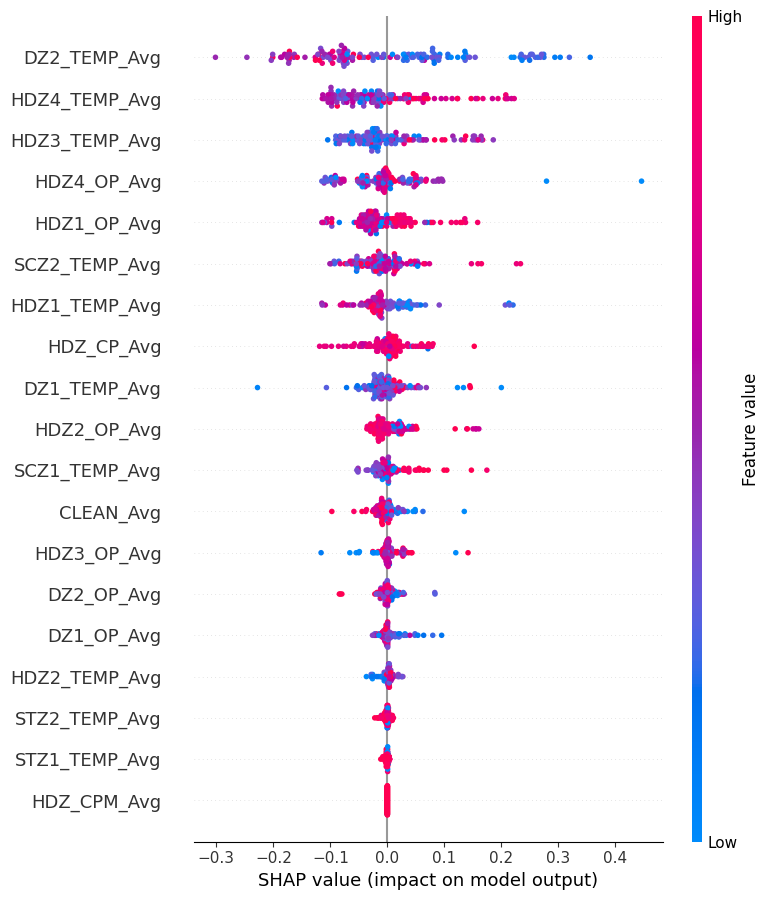

In [9]:
import shap
import xgboost as xgb
import numpy as np


df = pd.read_csv(r"C:\Users\KJS\Desktop\Test_df_quality_assurance.csv", encoding='utf-8')


# Define your features (X) and target variable (y) from random_sample
X = df.drop(columns=["DS"])
y = df["DS"]

# Train an XGBoost model on your random_sample data
model = xgb.XGBRegressor()
model.fit(X, y)

# Create a SHAP explainer
explainer = shap.Explainer(model)

# Compute SHAP values for the entire random_sample dataset
shap_values = explainer.shap_values(X)

# Summarize the feature importance using mean absolute SHAP values
feature_importance = np.abs(shap_values).mean(axis=0)

# Plot the SHAP summary plot or individual explanations as desired
shap.summary_plot(shap_values, X)


In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv(r"C:\Users\KJS\Desktop\encoded_data_date_6.csv", encoding='utf-8')

def get_pp_df(df, column):
    df = df.copy()
    
    # 데이터 컬럼에 이상치 값 0으로 배정
    df['Outlier'] = 0

    # IQR 계산
    thirdq, firstq = df[column].quantile(0.75), df[column].quantile(0.25)
    interquartilerange = 1.5 * (thirdq - firstq)
    outlierhigh, outlierlow = interquartilerange + thirdq, firstq - interquartilerange

    # 이상치 탐지
    df['Outlier'] = ((df[column] > outlierhigh) | (df[column] < outlierlow)).astype(int)
    
    # 요일별로 그룹화
    df.drop(['Minute', 'Second'], axis=1, inplace=True)

    df = df.groupby(['AN', 'Year', 'Month', 'Day', 'Hour']).agg({
        'DZ1_OP': 'mean',
        'DZ2_OP': 'mean',
        'DZ1_TEMP': 'mean',
        'DZ2_TEMP': 'mean',
        'CLEAN': 'mean',
        'HDZ1_OP': 'mean',
        'HDZ2_OP': 'mean',
        'HDZ3_OP': 'mean',
        'HDZ4_OP': 'mean',
        'HDZ_CP': 'mean',
        'HDZ_CPM': 'mean',
        'HDZ1_TEMP': 'mean',
        'HDZ2_TEMP': 'mean',
        'HDZ3_TEMP': 'mean',
        'HDZ4_TEMP': 'mean',
        'SCZ1_TEMP': 'mean',
        'SCZ2_TEMP': 'mean',
        'STZ1_TEMP': 'mean',
        'Outlier': 'sum'
    }).reset_index()
    
    Q3 = np.percentile(df['Outlier'], 75)
    
    df[f'{column}_Signal'] = np.where(df['Outlier'] <= Q3, 0, 1)
    df.drop(column, inplace=True, axis=1)
    
    return df

columns = ['DZ1_OP', 'DZ2_OP', 'DZ1_TEMP', 'DZ2_TEMP', 'CLEAN', 'HDZ1_OP', 'HDZ2_OP', 'HDZ3_OP', 'HDZ4_OP', 'HDZ_CP', 'HDZ_CPM', 'HDZ1_TEMP', 'HDZ2_TEMP', 'HDZ3_TEMP', 'HDZ4_TEMP', 'SCZ1_TEMP', 'SCZ2_TEMP', 'STZ1_TEMP']

df_dict = {}
for column in columns:
    df_dict[column] = get_pp_df(data, column)

for df in df_dict.values():
    df.drop(['AN', 'Year', 'Month', 'Day', 'Hour'], axis=1, inplace=True)


In [8]:
df_dict['DZ1_OP'].to_csv('DZ1_OP.csv', index=False)


# Deep Learning

# GRU

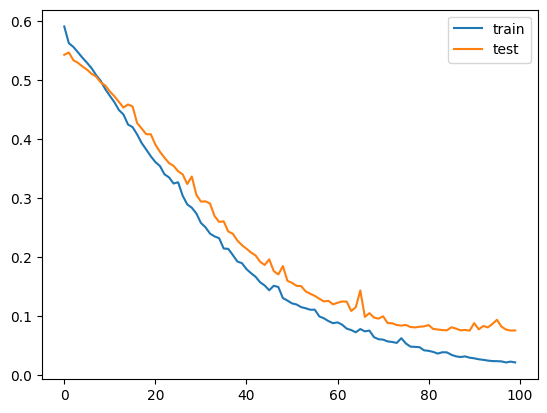

6/6 [==============================] - 0s 3ms/step
F1 Score: 0.9512195121951219
Accuracy: 0.975609756097561
Recall: 0.9512195121951219
Precision: 0.9512195121951219


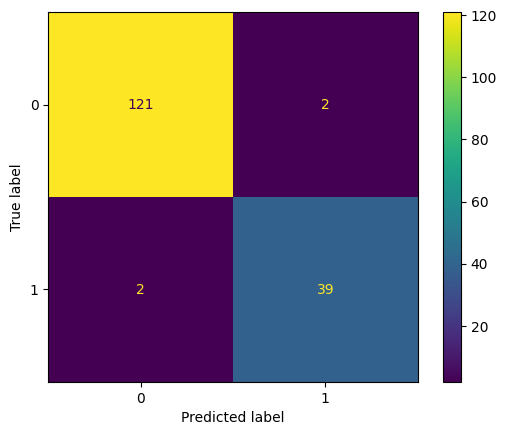

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       123
           1       0.95      0.95      0.95        41

    accuracy                           0.98       164
   macro avg       0.97      0.97      0.97       164
weighted avg       0.98      0.98      0.98       164



In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Load your data
df = df_dict['DZ1_OP']

# Specify your feature and label columns
feature_columns = df.columns.drop('DZ1_OP_Signal')
label_column = 'DZ1_OP_Signal'

# Define the number of time_steps
time_steps = 30

# Split your data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Scale your data
scaler = MinMaxScaler()
train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])

# Reshape the data to fit the GRU layer
X_train, y_train = [], []
X_test, y_test = [], []

# Create sequences with the specified time_steps
for i in range(len(train_df) - time_steps):
    X_train.append(train_df[feature_columns].values[i:i + time_steps])
    y_train.append(train_df[label_column].values[i + time_steps - 1])

for i in range(len(test_df) - time_steps):
    X_test.append(test_df[feature_columns].values[i:i + time_steps])
    y_test.append(test_df[label_column].values[i + time_steps - 1])

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

# Build your GRU model
model = Sequential()
model.add(GRU(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')

# Set early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train your model
history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.2, callbacks=[early_stopping])

# Plot loss and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Predict values
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_classes)
print(f'F1 Score: {f1}')

# Calculate Accuracy, Recall, Precision
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
fig, ax = plt.subplots()

# Use ConfusionMatrixDisplay for a more detailed confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax)
plt.show()

# Print Classification Report
print(classification_report(y_test, y_pred_classes))


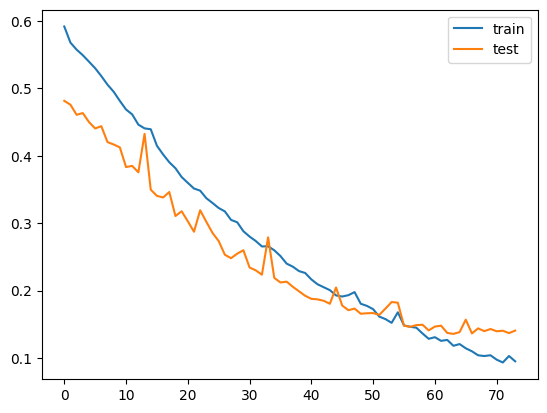

6/6 [==============================] - 0s 3ms/step
F1 Score: 0.8636363636363635
Accuracy: 0.926829268292683
Recall: 0.7916666666666666
Precision: 0.95


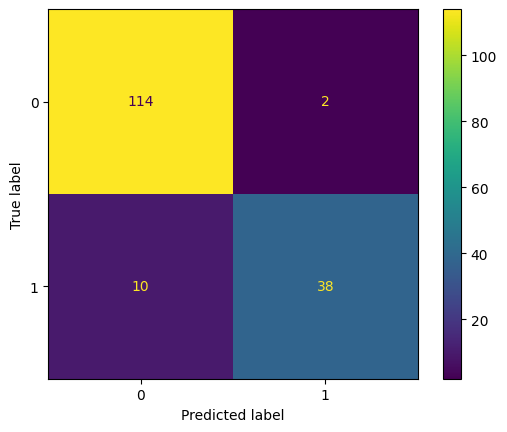

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       116
           1       0.95      0.79      0.86        48

    accuracy                           0.93       164
   macro avg       0.93      0.89      0.91       164
weighted avg       0.93      0.93      0.92       164



In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Load your data
df = df_dict['DZ2_OP']

# Specify your feature and label columns
feature_columns = df.columns.drop('DZ2_OP_Signal')
label_column = 'DZ2_OP_Signal'

# Define the number of time_steps
time_steps = 30

# Split your data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Scale your data
scaler = MinMaxScaler()
train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])

# Reshape the data to fit the GRU layer
X_train, y_train = [], []
X_test, y_test = [], []

# Create sequences with the specified time_steps
for i in range(len(train_df) - time_steps):
    X_train.append(train_df[feature_columns].values[i:i + time_steps])
    y_train.append(train_df[label_column].values[i + time_steps - 1])

for i in range(len(test_df) - time_steps):
    X_test.append(test_df[feature_columns].values[i:i + time_steps])
    y_test.append(test_df[label_column].values[i + time_steps - 1])

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

# Build your GRU model
model = Sequential()
model.add(GRU(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')

# Set early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train your model
history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.2, callbacks=[early_stopping])

# Plot loss and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Predict values
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_classes)
print(f'F1 Score: {f1}')

# Calculate Accuracy, Recall, Precision
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
fig, ax = plt.subplots()

# Use ConfusionMatrixDisplay for a more detailed confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax)
plt.show()

# Print Classification Report
print(classification_report(y_test, y_pred_classes))


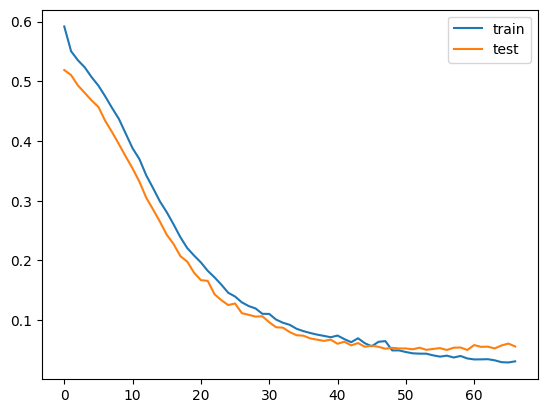

6/6 [==============================] - 1s 6ms/step
F1 Score: 0.9375
Accuracy: 0.9634146341463414
Recall: 0.9375
Precision: 0.9375


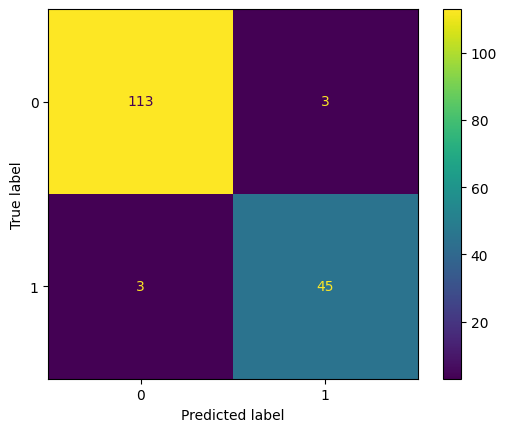

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       116
           1       0.94      0.94      0.94        48

    accuracy                           0.96       164
   macro avg       0.96      0.96      0.96       164
weighted avg       0.96      0.96      0.96       164



In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Load your data
df = df_dict['DZ1_TEMP']

# Specify your feature and label columns
feature_columns = df.columns.drop('DZ1_TEMP_Signal')
label_column = 'DZ1_TEMP_Signal'

# Define the number of time_steps
time_steps = 30

# Split your data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Scale your data
scaler = MinMaxScaler()
train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])

# Reshape the data to fit the GRU layer
X_train, y_train = [], []
X_test, y_test = [], []

# Create sequences with the specified time_steps
for i in range(len(train_df) - time_steps):
    X_train.append(train_df[feature_columns].values[i:i + time_steps])
    y_train.append(train_df[label_column].values[i + time_steps - 1])

for i in range(len(test_df) - time_steps):
    X_test.append(test_df[feature_columns].values[i:i + time_steps])
    y_test.append(test_df[label_column].values[i + time_steps - 1])

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

# Build your GRU model
model = Sequential()
model.add(GRU(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')

# Set early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train your model
history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.2, callbacks=[early_stopping])

# Plot loss and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Predict values
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_classes)
print(f'F1 Score: {f1}')

# Calculate Accuracy, Recall, Precision
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
fig, ax = plt.subplots()

# Use ConfusionMatrixDisplay for a more detailed confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax)
plt.show()

# Print Classification Report
print(classification_report(y_test, y_pred_classes))
